<div style="text-align:center">Marco Seiz, Michael Kellner, Anastasia August<br>
KIT, Institut für Angewandte Materialien (IAM)<br>
Computational Materials Science (CMS)
</div>
<h1>Mikrostruktursimulation <br/>Rechnerübung Implementierung der Phasenfeldmethode WS 20/21</h1>

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from math import ceil, floor
import numpy as np
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.figsize'] = (9,5)
mpl.rcParams['axes.grid'] = True
import time
from numba import jit
#import warnings
#warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
testfield = np.linspace(0, 1, 10)**3
correct_laplace = np.array([0.        , 0.00823045, 0.01646091, 0.02469136, 0.03292181,
       0.04115226, 0.04938272, 0.05761317, 0.06584362, 0.        ])
correct_a = np.array([0.        , 0.08230453, 0.16460905, 0.24691358, 0.32921811,
       0.41152263, 0.49382716, 0.57613169, 0.65843621, 0.        ])
correct_w = np.array([ 0.        ,  0.00491797,  0.03821507,  0.11888432,  0.23768184,
        0.33604882,  0.30580704,  0.05290172, -0.30455913,  0.        ])
correct_f = np.array([0.        , 0.00032877, 0.00260484, 0.00855967, 0.0192202 ,
       0.03409598, 0.05004115, 0.05979125, 0.05017483, 0.        ])


def tester(testfunc, testfield, correct):
    fncname = testfunc.__name__
    if fncname == "f":
        vals = testfunc(testfield, 0.98)
    else:
        vals = testfunc(testfield)
    diff = np.sum(np.abs(vals - correct))
    if diff < 1e-6:
        print(fncname + " works")
        return True
    else:
        print(fncname + " doesn't work")
        return False
# Randbedingungen
def neumannzero(field):
    field[0] = field[1]
    field[-1] = field[-2]
    
def periodic(field):
    field[0] = field[-2]
    field[-1] = field[1]

## Aufgabe 1: 1D-Phasenfeldgleichung ##

In dieser Aufgabe soll die 1D-Phasenfeldgleichung

$
\begin{align}
\tau \epsilon \frac{\partial \phi}{\partial t} &= a(\phi) - w(\phi) + f(\phi, T)\\
a(\phi) &= 2\sigma\epsilon \frac{\partial^2\phi}{\partial x^2}\\
w(\phi) &= \frac{18\sigma}{\epsilon}(2\phi^3 - 3\phi^2 + \phi)\\
f(\phi,T) &= 6L_\alpha \frac{T_m - T}{T_m}(\phi-\phi^2)
\end{align}
$

implementiert werden. Es wird angenommen, dass die Temperatur $T$ im Gebiet konstant ist. Die Simulationsparameter sind in der nächsten Zelle definiert.

In [3]:
deltax = 1
T = 1.0
sigma = 1.0
tau = 5.0
epsilon = 5 
T_m = 1.0
L_a = 2
deltat = (1/tau / epsilon) * (1 / deltax)**2 
physlen = 1 * 80
numx=int(physlen / deltax)


### 1a) Evolutionsterme  ###
Implementieren Sie die Terme $a$, $w$ und $f$ aus der Phasenfeldgleichung. Für die Berechnung von $a$ wird die zweite Ableitung (Laplace) des Ordnungsparameterfelds $\phi$ benötigt; nutzen Sie zentrale finite Differenzen zweiter Ordnung für die Berechnung dessen.

Das $\phi$-Argument für a, w, f entspricht einem ganzen Feld (Array) und diese geben auch ganze Felder wieder zurück. Sie können dies über das sog. broadcasting von numpy bequem lösen, indem Sie mit dem ganzen Feld auf einmal rechnen, siehe die nächste Zelle für ein Beispiel.

Der Laplace soll jedoch mit einer Schleife über das Feld berechnet werden.

**Hinweis**: Sie können einzelne Funktionsimplementierungen mit

tester(functionname, testfield, correct_functionname)

z.B.

tester(f, testfield, correct_f)

auf Korrektheit überprüfen.

In [4]:
bsp = np.linspace(1, 10, 10) # 1 bis 10 inklusive
print(bsp) # wie gehabt
print(bsp**2) # hier wird die Operation mit jedem Element durchgeführt!

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[  1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]


In [5]:
@jit
def laplace(field):
    lapl = np.zeros_like(field)
    length = field.shape[0]
    #for i in range(2, length-2, 1): # für das Verfahren 4. Ordnung 
    for i in range(1, length-1, 1):
        # Verfahren 2. Ordnung
        lapl[i] = \
        (field[i-1] - 2*field[i] + field[i+1]) / (deltax*deltax) 
        # Verfahren 4. Ordnung 
        #lapl[i] = (-1/12.0 * field[i-2] + 4.0/3.0 * field[i-1] 
        #- 2.5 * field[i] + 4.0/3.0 * field[i+1] - 1/12.0 * field[i+2]) / (deltax * deltax)  
    # für das Verfahren 4. Ordnung müssen die Laplacewerte in Zellen 1 und -2 separat berechnt werden 
    # da das zentrale Verfahren 4. Ordnung hier auf Werte außerhalb des Gebiets zugreifen würde 
    # es werden hierzu gerichtete Differenzen der 2. Ableitung von 4. Ordnung benutzt 
    #lapl[1] = (15/4.0 * field[1] - 77/6.0 * field[2] 
    #           + 107/6.0 * field[3] - 13 * field[4] + 61/12.0 * field[5] 
    #          - 5/6.0 * field[6]) 
    #lapl[-2] = (15/4.0 * field[-1] - 77/6.0 * field[-2] 
    #           + 107/6.0 * field[-3] - 13 * field[-4] + 61/12.0 * field[-5] 
    #          - 5/6.0 * field[-6]) 
    return lapl 

@jit
def a(phi):
    laplacephi = laplace(phi)
    return \
    2*sigma*epsilon*laplacephi 

@jit
def w(phi):
    return \
    18*sigma / epsilon * (2*phi**3 - 3*phi**2 + phi) 

@jit
def f(phi, T=1.0):
    return \
    6*L_a * (T_m-T) / (T_m ) * (phi - phi**2) 



In [6]:
tester(f, testfield, correct_f)

f works


True

### 1b) Zeitintegration ###
Implementieren Sie die Zeitintegration mit dem expliziten Eulerverfahren für die Phasenfeldgleichung.

In [7]:
@jit
def explEuler(phiold, phinew):
    length = phiold.shape[0]
    aa = a(phiold)
    ww = w(phiold)
    ff = f(phiold, T)
    for i in range(1, length-1, 1):
        phinew[i] = \
        phiold[i] + deltat * (aa[i] - ww[i] + ff[i]) / (tau * epsilon) 
        


### Anfangsbedinungen ###

In [8]:
def ini(field):
    length = field.shape[0]
    field[:int(length/2)] = 1 # von Anfang bis zur Mitte 1 = fest
    field[int(length/2):] = 0 # und dahinter 0 = flüssig

### 1c) Simulation ###
Führen Sie nun die Simulation aus und beobachten Sie das Phasenfeldprofil für verschiedene Zeiten. Beschreiben Sie die Evolution des Phasenfelds.

Aus dem initialen scharfen Übergang wird ein diffuser Übergang ohne, dass sich das Interface bewegt. 

Weiter unten unter "Visualisierung" ist der Plotbefehl für das Gleichgewichtsprofil auskommentiert. Aktivieren Sie diesen und vergleichen Sie die numerische und analytische Lösung. Beachten Sie dabei, dass das Erreichen des Gleichgewichts ein zeitabhängiger Prozess ist.

Bis zur Simulationszeit 20 gibt es noch visuelle Unterschiede. Wird jedoch bis zur Simulationszeit 40 gerechnet gibt es visuell fast keine Unterschiede mehr, d.h. die numerische Lösung nähert die analytische Lösung gut an. 

Wie könnte die analytische Lösung im Gleichgewicht besser getroffen werden?

Der Unterschied beruht auf Fehlern, die beim numerischen Lösen der PDE entstehen. Da die Gleichgewichtslösung dem stationären Zustand entspricht ($\frac{\partial \phi}{\partial t} = 0$), spielt die Zeitintegration nur insofern eine Rolle, ob diese zu einem stationären Zustand konvergiert, was für eine stabile Zeitschrittweite der Fall ist. Insofern muss die Genauigkeit der örtlichen Diskretisierung erhöht werden, was z.B. über eine höhere Gitterauflösung oder mit einem Verfahren höherer Ordnung für den Laplace realisiert werden kann. In der Lösung ist für den Laplace zusätzlich ein Verfahren 4. Ordnung implementiert, welches einen geringere Abweichung von der analytischen Lösung zeigt, vgl. hierzu die Berechnung der $L^2$-Norm. 

In [9]:
# Initialisierung der Felder
phiold = np.zeros(numx)
phinew = np.zeros(numx)
ini(phiold)
framelist = []
times = []
t=0

# Parameter zur Variation. 
# Über <funktion>.recompile werden die Änderungen an T/tau/epsilon den Funktionen sichtbar gemacht.
tau = 5
epsilon = 5
T = 1
a.recompile()
w.recompile()
f.recompile()
explEuler.recompile()

In [10]:
goaltime = 40
timesteps= int(goaltime / deltat)
writefreq= int(timesteps / 20)

neumannzero(phiold)
start = time.time()
for i in range(timesteps+1):
    if i%writefreq == 0:
        framelist.append(phiold.copy())
        times.append(t)
        
    explEuler(phiold, phinew)
    neumannzero(phinew)
    # swap new and old field
    phiold, phinew = phinew, phiold
    t+=deltat
end = time.time()
print("Laufzeit: %f Sekunden" % (end-start))
framecount = len(framelist)-1

Laufzeit: 0.677132 Sekunden


In [11]:
# Gitterpunkte
xx = np.linspace(0, numx-1, numx)
# und die analytische Lösung im Gleichgewicht (GGW), verschoben zur Gebietsmitte
phi_eq = 0.5 * (1- np.tanh(1.5 * deltax * (xx-(numx-1)/2) / epsilon))

In [12]:
# L^2-Norm für die Abweichung der analytischen zur numerischen Lösung: kleiner = besser
np.sum( (phi_eq - framelist[-1])**2)

9.508477826045803e-05

# Visualisierung

<IPython.core.display.Javascript object>


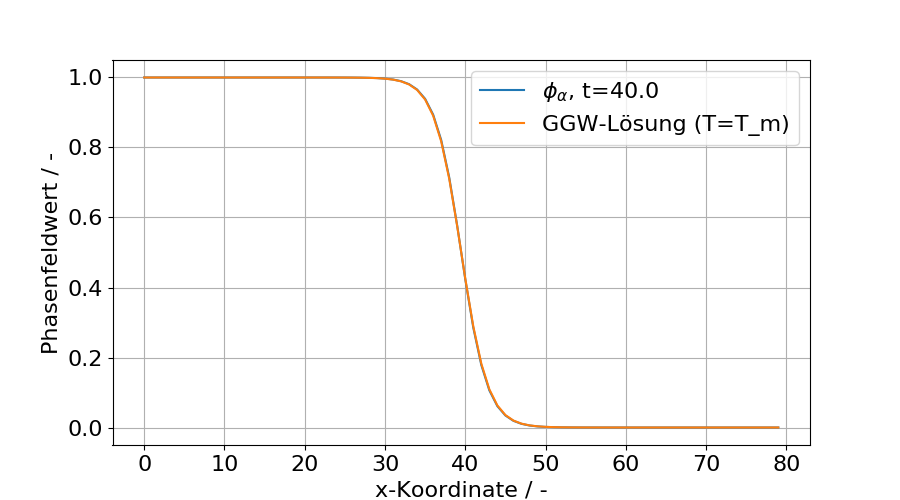

In [32]:

fig, ax = plt.subplots()

linephi, = ax.plot(xx, framelist[-1], label=r"$\phi_\alpha$, t=%.1f" % (times[-1]))
ax.plot(xx, phi_eq, label="GGW-Lösung (T=T_m)")

ax.legend()
ax.set_xlabel("x-Koordinate / -")
ax.set_ylabel("Phasenfeldwert / -")
ax.legend()
fig.canvas.draw()


def plotter(frame):
    frame = frame -1
    linephi.set_ydata(framelist[int(frame)])
    linephi.set_label(r"$\phi_\alpha$, t=%.1f" % (times[int(frame)]))
    ax.legend()
    fig.canvas.draw()

In [14]:
interact(plotter, frame=widgets.IntSlider(min=1, max=framecount, step=1, value=1))

interactive(children=(IntSlider(value=1, description='frame', max=20, min=1), Output()), _dom_classes=('widget…

<function __main__.plotter(frame)>

### 1d) Parametervariation ###
Wie verändert sich das Simulationsergebnis, wenn Sie die Parameter $\epsilon$, und $\tau$ variieren? Ändern Sie hierzu die vorgegeben Parameter in der Zelle mit "Parameter zur Variation." und führen Sie diese Zellen und die nachfolgenden bis zur Visualisierung aus.

Beispiele: $\epsilon=10$, $\tau=1.0$, $\tau=100.0$


Der Parameter $\epsilon$ bestimmt die Interfacebreite. $\tau$ hingegen kontrolliert wie schnell sich das Interface einstellt.

### 1e) Treibende Kraft
Bisher lag keine treibende Kraft für die Phasenumwandlung vor, da die Temperatur $T$ der Schmelztemperatur $T_m$ entsprach. Ändern Sie diese wie $\epsilon$ und $\tau$ und beschreiben Sie, wie sich das Simulationsergebnis ändert.

Beispiele: $T=0.5$, $T=1.5$

Die Temperatur bestimmt die Größe und Richtung der treibenden Kraft. Die treibende Kraft bestimmt, in welche Richtung sich das Interace bewegt. Bei Temperaturen unterhalb des Schmelzpunkts wächst die feste Phase, während darüber die flüssige Phase wächst.

## Aufgabe 2: 2D-Phasenfeldgleichung ##
In dieser Aufgabe ist die 2D-Phasenfeldgleichung schon implementiert. 

### 2a) Parametervariation ###
Untersuchen Sie den Einfluss der Parameter ($\tau$, $\epsilon$, $\sigma$), indem Sie die Werte in der folgenden Zelle ändern und die Simulation starten. Beschreiben und erklären Sie die Evolution des Phasenfeldes.

Auch hier wird der initiale scharfe Übergang zunächst diffus. Weiterhin schrumpft der Kreis aufgrund der Kapillarkräfte. $\tau$ wie auch $\epsilon$ beeinflussen die Simulation wie in 1D. $\sigma$ beeinflusst, wie schnell der Kreis wegschrumpft, da die Kapillarkräfte proportional zu $\sigma$ sind.

In [15]:
deltaX=1
deltaY=1
T_m=1
#T=0.75


L_a=0.5
deltat=0.08
NumX=61 
NumY=61


In [16]:
@jit
def ini_rectangle(field, ulc_x, ulc_y, w, h):
    # Setzen des Anfangsfillings: Rechteck mit Angabe des oberen linken Eckes + Breite, Höhe
    for i in range(ulc_x, ulc_x + w):
        for j in range(ulc_y, ulc_y + h):
            field[i][j]= 1

@jit            
def ini_circle(field, cx, cy, r):
    # Setzen des Anfangsfillings: Kreis
    nx2 = int(cx) 
    ny2 = int(cy) 
    for i in range(nx2 - r, nx2 + r + 1):
        for j in range(ny2 - r, ny2 + r + 1):
            if (i-nx2)**2 + (j-ny2)**2 <= r**2:
                field[i][j]= 1            


@jit
def bcs(field):
    #Randbedingungen (Neumann-Null-Rand)
    for i in range(0, NumX):
        field[i][0]=field[i][1]
        field[i][NumY-1]=field[i][NumY-2]
     
    for i in range(0, NumY):
        field[0][i]=field[1][i]
        field[NumX-1][i]=field[NumX-2][i]
    
@jit
def calc_phi(phi_old, phi_new):
    for i in range(1, NumX-1):
        for j in range(1, NumY-1):

            a_x=2*sigma*(phi_old[i+1][j]-2*phi_old[i][j]+phi_old[i-1][j])/(deltaX**2)
            a_y=2*sigma*(phi_old[i][j+1]-2*phi_old[i][j]+phi_old[i][j-1])/(deltaY**2)
            w=-18/(epsilon**2)*sigma*(2*phi_old[i][j]**3-3*phi_old[i][j]**2+phi_old[i][j])
            L=L_a*(T_m-T)/T_m
            f=L/epsilon*6*(phi_old[i][j]-phi_old[i][j]**2)

            phi_new[i][j]=phi_old[i][j]+ deltat/tau *(a_x+a_y+w+f) 

In [17]:
# Parametervariation 
T=0.95
sigma=1.0
tau=2.0
epsilon=5
calc_phi.recompile()

In [18]:
# Anlegen des Gebietes (aktueller und neuer Zeitschritt)
phi_new  = np.zeros(NumX*NumY).reshape(NumX,NumY)
phi_old  = np.zeros(NumX*NumY).reshape(NumX,NumY)
radius=15
# Geometrie 1: Nur ein fester Keim in der Mitte des Gebiets
ini_circle(phi_old, NumX/2, NumY/2, radius)
# Geometrie 2: Die obere Hälfte des Gebiets ist fest, die untere flüssig; ini_circle darüber auskommentieren
#ini_rectangle(phi_old, 0,0, int(NumX/2), NumY)
# Geometrie 3: Beide Geometrien zusammen aufstellen.
framelist2d=[]
phisums=[]
times2d=[]
t2d=0

In [19]:
timesteps=5000
writefreq=250
bcs(phi_old)
start = time.time()
for i in range(timesteps):
    if i%writefreq == 0:
        framelist2d.append(phi_old.copy())
        times2d.append(t2d)
        phisums.append(np.sum(phi_old))
    calc_phi(phi_old, phi_new)
    bcs(phi_new)
    phi_old, phi_new = phi_new, phi_old
    t2d += deltat


end = time.time()
print("Laufzeit: %f Sekunden" % (end-start))
framecount2d = len(framelist2d) - 1 

Laufzeit: 0.444844 Sekunden


<IPython.core.display.Javascript object>


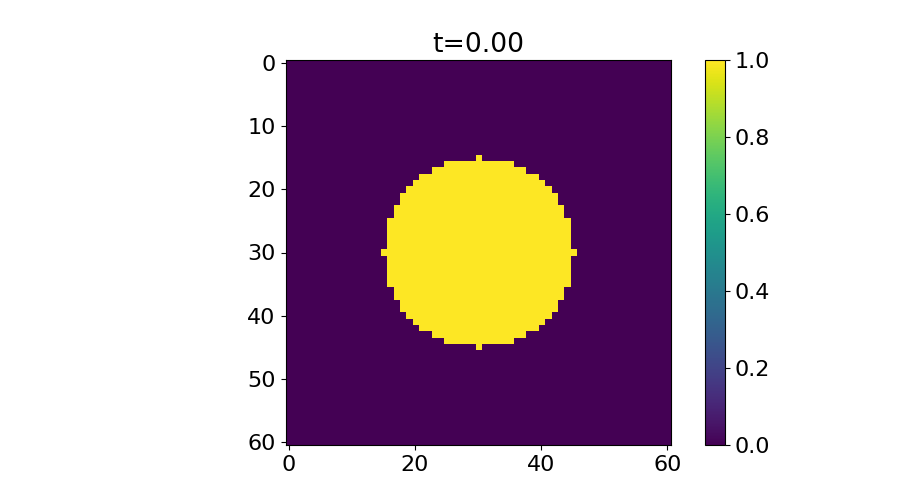

In [20]:
fig2d, ax2d = plt.subplots()
im = ax2d.imshow(framelist2d[0], vmin=0, vmax=1)
fig2d.colorbar(im)
fig2d.canvas.draw()
ax2d.set_title("t=%.2f" % times2d[0])
ax2d.grid(False)

def plotter2d(frame):
    frame = frame -1
    im = ax2d.imshow(framelist2d[int(frame)], vmin=0, vmax=1)
    ax2d.set_title("t=%.2f" % times2d[int(frame)])
    fig2d.canvas.draw()

    
#interact(plotter2d, frame=widgets.BoundedFloatText(min=0, max=framecount2d, step=1, value=0))

In [21]:
interact(plotter2d, frame=widgets.BoundedIntText(min=1, max=framecount2d, step=1, value=1))

interactive(children=(BoundedIntText(value=1, description='frame', max=19, min=1), Output()), _dom_classes=('w…

<function __main__.plotter2d(frame)>

In [22]:
for ttime, frame in zip(times2d, framelist2d):
    print(ttime, np.sqrt(np.sum(frame[1:-1,1:-1]) / np.pi))
    # summe der Phasenfeldwerte entspricht der Fläche/Volumen der Phase, damit Umrechnung in effektiven Radius
    # unter Annahme eines Kreises

0 15.022706457370044
19.999999999999925 14.404119484285879
39.9999999999995 13.449656962496942
59.999999999999076 12.372812259058536
79.99999999999865 11.131335727651182
99.99999999999822 9.64289475256115
119.9999999999978 7.713712812394398
139.9999999999995 4.48929611514102
160.00000000000261 0.268160232546826
180.00000000000574 0.008114637797194534
200.00000000000887 0.00024540761603116304
220.000000000012 7.421758321273914e-06
240.00000000001512 2.2445308527982567e-07
260.0000000000168 6.788039344695179e-09
280.00000000001285 2.0528779137825154e-10
300.00000000000887 6.208431499722396e-12
320.0000000000049 1.8775895745171307e-13
340.0000000000009 5.67831441885612e-15
359.99999999999693 1.7172685168792265e-16
379.99999999999295 5.1934622522340846e-18


### 2b) Einfluss der Kapillarität
Im Gegensatz zum 1D-Fall gibt es in höheren Dimensionen eine treibende Kraft durch Oberflächenspannung. Wie groß muss die Unterkühlung $\Delta T = T_m - T$ sein, dass diese die Kapillarkraft ausgleicht und damit der Keim stabil bleibt?

**Hinweis**: Stellen Sie die Gesamtenergie des 2D-Systems bestehend aus dem Beitrag für Phasenumwandlung ($G_A = L_\alpha \frac{\Delta T}{T_m}$) und dem der Kapillarität ($G_U = \sigma$) auf. Beide Beiträge werden von der Geometrie über den Radius $r$ beeinflusst. Die Lösung davon lässt sich von Hand wie auch mit sympy symbolisch bestimmen.

Die kritische Unterkühlung lässt sich wie unten gezeigt herleiten, indem die Gesamtenergie nach dem Radius abgeleitet und gleich Null gesetzt wird. Setzt man diese Unterkühlung, so ist der Keim jedoch noch in geringem Maße am Schrumpfen. Dies ist bedingt durch die scharfen Anfangsbedingungen, die dann in ein diffuses Profil übergehen. Dies ist in der Berechnung nicht berücksichtigt worden. 

In [23]:
from sympy import *
init_printing()

In [24]:
dT = symbols("dT")
Tm = symbols("T_m")
r = symbols("r")
sigmasym = symbols("sigma")
La = symbols("L_\\alpha")

In [25]:
A = math.pi * r**2 
U = 2*math.pi*r
G_A = La * dT/Tm
G_U = sigmasym
G_A_int =  G_A * A 
G_U_int = G_U * U 

In [26]:
G_total = -G_A_int + G_U_int  

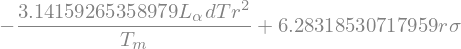

In [27]:
display(G_total) 

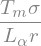

In [28]:
dG = diff(G_total,r) 
dT_eq = solve(dG, dT)[0] 
display(dT_eq) 

In [29]:
print(T_m, radius, sigma, L_a) 

1 15 1.0 0.5


In [30]:
print("Kritische Unterkühlung: %f" % (dT_eq.subs({Tm:T_m, r: radius, sigmasym: sigma, La: L_a}))) 

Kritische Unterkühlung: 0.133333


### 2c) Geometrievariation
Bei 2a) unter "Anlegen des Gebietes (aktueller und neuer Zeitschritt)" sind drei verschiedene Geometrien definiert, von denen Sie soweit die Geometrie 1 untersucht haben. Setzen Sie die entsprechenden Geometrien und diskutieren Sie die Ergebnisse in Hinblick auf die Unterschiede zwischen Simulationen in einer und mehreren Dimensionen.

Bei Geometrie 2 wird eine planare Grenzfläche gesetzt. Dies entspricht einer 1D-Phasenfeldgleichung für jeden Punkt darauf, da die Ableitung quer zum Interface überall 0 beträgt. 

Bei Geometrie 3 bildet sich der Halbkreis auf der planaren Grenzfläche zurück. Dies ist bedingt durch den Einfluss der Kapillarität in zwei Dimensionen. Nachdem die Grenzfläche nur noch planar ist entspricht das Verhalten dem der zweiten Geometrie. 
